# Face Recognition Project

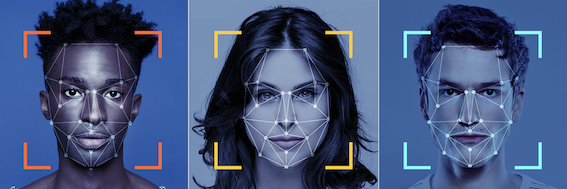

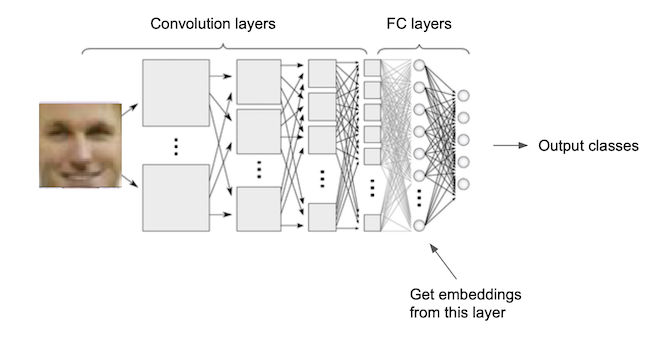

## Task 1 (2 points): build a neural network for faces classification as discribed above.

### Dataset 

In [27]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.ru/d/dZ8C8QsUx8wI8w) -o celebA_train.zip
! unzip -qq celebA_train.zip

!ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  171M  100  171M    0     0  5679k      0  0:00:30  0:00:30 --:--:-- 3648k
replace __MACOSX/._celebA_train_1k? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace celebA_train_1k/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace __MACOSX/celebA_train_1k/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace celebA_train_1k/celebA_train_split.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/celebA_train_1k/._celebA_train_split.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace celebA_train_1k/celebA_anno.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/celebA_train_1k/._celebA_anno.txt? [y]es, [n]o, [A]ll, [N]one

Let's look at the data first:

In [28]:
!ls

celebA_train_1k  celebA_train.zip  celebA.zip  __MACOSX  sample_data


In [29]:
! ls celebA_train_1k/

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


- celebA_imgs — folder with aligned images 
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [43]:
import os
import cv2
import numpy as np
from PIL import Image
from skimage import io, transform

from tqdm import tqdm, tqdm_notebook


import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

Let's visualize some images to understand what we're dealing with:

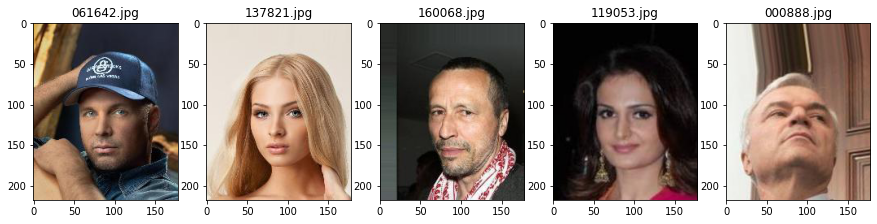

In [33]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
      img = Image.open(os.path.join('celebA_train_1k/celebA_imgs/', img))
      imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()

images_names = os.listdir('./celebA_train_1k/celebA_imgs/')[:5]
show_imgs(images_names)


### Train Neural Network

Let's build a Datasets and network using this images:

In [37]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_train_1k/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:            
        images_paths.append(os.path.join('celebA_train_1k/celebA_imgs/', filename))
    
    return np.array(images_paths)


class celebADataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_train_1k/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]

        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        img_name = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_name) 
        
        if self.aug:
            sample = self.aug(
                image=image,
            )
        else:
            sample = {
                'image': image,
                'label': label,
            }
        
        sample['image'] = self.transform(sample['image'])
        sample['label'] = int(sample['label'])

        return sample

In [35]:
transform = transforms.Compose([transforms.Resize(160),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                              ])

In [38]:
train_data = celebADataset('train', transform)
val_data = celebADataset('val', transform)
test_data = celebADataset('test', transform)

In [39]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# YOUR CODE HERE: train your model on train set and evaluate it on test set

In [41]:
def eval_epoch(model,val_loader,criterion):
  
  model.eval()
  
  r_loss = 0.0
  r_correct = 0
  proc_size = 0

  for batch in val_loader:

    inputs = batch['image'].to(device)
    labels = batch['label'].to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs).to(device)
      loss = criterion(outputs, labels)
      preds = torch.argmax(outputs, 1)

    r_loss += loss.item() * inputs.size(0)
    r_correct += torch.sum(preds == labels.data)
    proc_size += inputs.size(0)

  val_loss = r_loss / proc_size
  val_acc = r_correct.double() / proc_size
  return val_loss, val_acc


In [42]:
def fit_epoch(model, train_loader, criterion, optimizer):
    
  model.eval()
  
  r_loss = 0.0
  r_correct = 0
  proc_data = 0

  for batch in train_loader:
    
    inputs = batch['image'].to(device)
    labels = batch['label'].to(device)

    optimizer.zero_grad()

    outputs = model(inputs).to(device)
    
    loss = criterion(outputs, labels)
    loss.backward()
    
    optimizer.step()
    
    preds = torch.argmax(outputs, 1)
    
    r_loss += loss.item() * inputs.size(0)
    r_correct += torch.sum(preds == labels.data)
    proc_data += inputs.size(0)
          
  train_loss = r_loss / proc_data
  train_acc = r_correct.cpu().numpy() / proc_data
  return train_loss, train_acc
    


In [44]:
def train(train_loader, val_loader, model, epochs, optimizer, criterion):
    
    history = []
    
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        for epoch in range(epochs):
            
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

def test_accuracy(test_loader, model):
    
    model.eval()
    
    r_correct = 0
    proc_size = 0
    
    for batch in test_loader:
        
        inputs = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs).to(device)
            preds = torch.argmax(outputs, 1)
        r_correct += torch.sum(preds == labels.data)
        proc_size += inputs.size(0)
    
    test_acc = r_correct.double() / proc_size
    
    return test_acc.item()

In [45]:
! git clone https://github.com/timesler/facenet-pytorch.git
! mv facenet-pytorch/models ./

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 1267, done.
remote: Total 1267 (delta 0), reused 0 (delta 0), pack-reused 1267
Receiving objects: 100% (1267/1267), 22.88 MiB | 17.29 MiB/s, done.
Resolving deltas: 100% (619/619), done.


In [60]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.2 MB/s eta 0:00:00


In [61]:
from facenet_pytorch import  InceptionResnetV1

In [62]:
model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = 1000)


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [63]:
layers = []

for name, param in model.named_parameters():
    
    good_name = name.strip().split(".") 
    
    if good_name[0] not in layers:
        layers.append(good_name[0])

for name, param in model.named_parameters():
    good_name = name.strip().split(".")
    
    if good_name[0] not in layers[-3:]:
        param.requires_grad = False

model.logits = torch.nn.Linear(in_features=512, out_features = 1000, bias=True)

model = model.to(device)

In [66]:
opt = torch.optim.AdamW(model.parameters(), amsgrad = True)
criterion = torch.nn.CrossEntropyLoss()
history = train(train_loader, val_loader, model= model, epochs=25, optimizer = opt, criterion= criterion)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 0.4677054029382693


epoch:   4%|▍         | 1/25 [01:08<27:34, 68.93s/it]


Epoch 001 train_loss: 0.4677     val_loss 1.4137 train_acc 0.8812 val_acc 0.7594
loss 0.3693441834686885


epoch:   8%|▊         | 2/25 [02:17<26:26, 68.96s/it]


Epoch 002 train_loss: 0.3693     val_loss 1.4441 train_acc 0.9062 val_acc 0.7658
loss 0.305880185237218


epoch:  12%|█▏        | 3/25 [03:25<25:04, 68.39s/it]


Epoch 003 train_loss: 0.3059     val_loss 1.5164 train_acc 0.9219 val_acc 0.7714
loss 0.25756234147334267


epoch:  16%|█▌        | 4/25 [04:33<23:50, 68.13s/it]


Epoch 004 train_loss: 0.2576     val_loss 1.5032 train_acc 0.9335 val_acc 0.7794
loss 0.2311460334365532


epoch:  20%|██        | 5/25 [05:41<22:41, 68.05s/it]


Epoch 005 train_loss: 0.2311     val_loss 1.6387 train_acc 0.9384 val_acc 0.7642
loss 0.2432890482826725


epoch:  24%|██▍       | 6/25 [06:49<21:30, 67.95s/it]


Epoch 006 train_loss: 0.2433     val_loss 1.6298 train_acc 0.9356 val_acc 0.7744
loss 0.21540753213308944


epoch:  28%|██▊       | 7/25 [07:56<20:22, 67.89s/it]


Epoch 007 train_loss: 0.2154     val_loss 1.6787 train_acc 0.9422 val_acc 0.7797
loss 0.1680075682473163


epoch:  32%|███▏      | 8/25 [09:04<19:12, 67.78s/it]


Epoch 008 train_loss: 0.1680     val_loss 1.6938 train_acc 0.9558 val_acc 0.7768
loss 0.13890551989529668


epoch:  36%|███▌      | 9/25 [10:12<18:04, 67.78s/it]


Epoch 009 train_loss: 0.1389     val_loss 1.7367 train_acc 0.9617 val_acc 0.7773
loss 0.10707010598502303


epoch:  40%|████      | 10/25 [11:19<16:56, 67.75s/it]


Epoch 010 train_loss: 0.1071     val_loss 1.7507 train_acc 0.9694 val_acc 0.7757
loss 0.0856800243736327


epoch:  44%|████▍     | 11/25 [12:27<15:47, 67.68s/it]


Epoch 011 train_loss: 0.0857     val_loss 1.7261 train_acc 0.9763 val_acc 0.7821
loss 0.05624799900338944


epoch:  48%|████▊     | 12/25 [13:35<14:40, 67.74s/it]


Epoch 012 train_loss: 0.0562     val_loss 1.7031 train_acc 0.9842 val_acc 0.7875
loss 0.03359884654074686


epoch:  52%|█████▏    | 13/25 [14:42<13:32, 67.71s/it]


Epoch 013 train_loss: 0.0336     val_loss 1.6499 train_acc 0.9904 val_acc 0.7923
loss 0.01815970495805863


epoch:  56%|█████▌    | 14/25 [15:50<12:24, 67.70s/it]


Epoch 014 train_loss: 0.0182     val_loss 1.6291 train_acc 0.9961 val_acc 0.7958
loss 0.009106165455316052


epoch:  60%|██████    | 15/25 [16:58<11:16, 67.64s/it]


Epoch 015 train_loss: 0.0091     val_loss 1.6059 train_acc 0.9979 val_acc 0.7982
loss 0.004911399880945722


epoch:  64%|██████▍   | 16/25 [18:05<10:08, 67.64s/it]


Epoch 016 train_loss: 0.0049     val_loss 1.5767 train_acc 0.9992 val_acc 0.8019
loss 0.003925105656438911


epoch:  68%|██████▊   | 17/25 [19:13<09:01, 67.69s/it]


Epoch 017 train_loss: 0.0039     val_loss 1.5697 train_acc 0.9995 val_acc 0.8014
loss 0.004486704481559171


epoch:  72%|███████▏  | 18/25 [20:20<07:53, 67.60s/it]


Epoch 018 train_loss: 0.0045     val_loss 1.5405 train_acc 0.9996 val_acc 0.8033
loss 0.0035584268925917257


epoch:  76%|███████▌  | 19/25 [21:28<06:45, 67.58s/it]


Epoch 019 train_loss: 0.0036     val_loss 1.5378 train_acc 0.9995 val_acc 0.8027
loss 0.003556476454629319


epoch:  80%|████████  | 20/25 [22:35<05:37, 67.55s/it]


Epoch 020 train_loss: 0.0036     val_loss 1.5243 train_acc 0.9996 val_acc 0.8022
loss 0.0039030699961445856


epoch:  84%|████████▍ | 21/25 [23:43<04:30, 67.55s/it]


Epoch 021 train_loss: 0.0039     val_loss 1.5224 train_acc 0.9995 val_acc 0.8025
loss 0.003820011577504065


epoch:  88%|████████▊ | 22/25 [24:51<03:22, 67.60s/it]


Epoch 022 train_loss: 0.0038     val_loss 1.5057 train_acc 0.9995 val_acc 0.8046
loss 0.0029395434198540727


epoch:  92%|█████████▏| 23/25 [25:58<02:15, 67.58s/it]


Epoch 023 train_loss: 0.0029     val_loss 1.5033 train_acc 0.9996 val_acc 0.8049
loss 0.0033802076120203733


epoch:  96%|█████████▌| 24/25 [27:06<01:07, 67.57s/it]


Epoch 024 train_loss: 0.0034     val_loss 1.4833 train_acc 0.9996 val_acc 0.8051
loss 0.0026639916533527193


epoch: 100%|██████████| 25/25 [28:13<00:00, 67.75s/it]


Epoch 025 train_loss: 0.0027     val_loss 1.4772 train_acc 0.9997 val_acc 0.8057


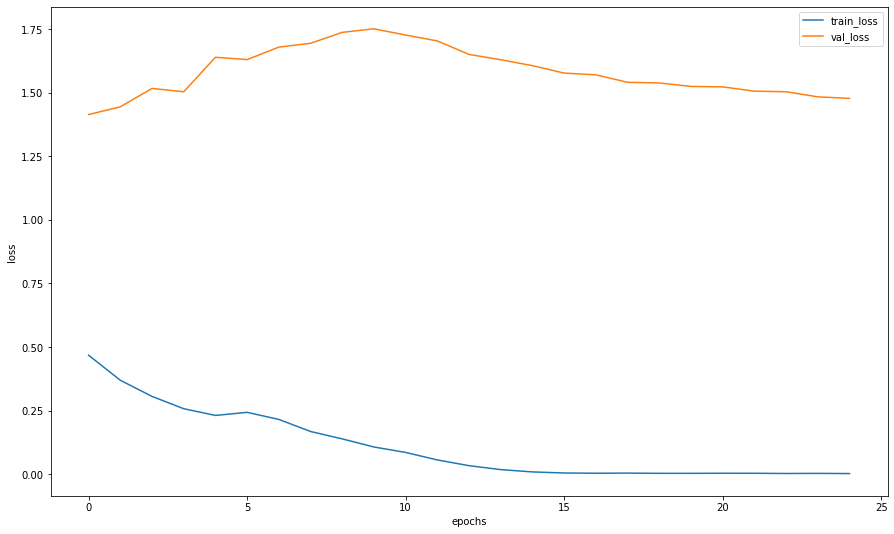

In [67]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label = "train_loss")
plt.plot(val_loss, label = "val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [68]:
torch.save(model.state_dict(), "model_weights.pth") 

In [69]:
test_acc = test_accuracy(test_loader, model)
print("Test accuracy: ", test_acc)

Test accuracy:  0.800252047889099


## Task 2 (2 points): Identificaton rate metric

## Task 3 (4 points): Loss functions

## Bonus task (0.5 points): Finding trash photos 